# Train-Test Split

In [1]:
import os
os.chdir(os.environ['PWD'])

Import Libraries

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_palette('colorblind')
from app.conf import settings as sts
from app.conf import utils as uts
from app.conf import model_utils as muts
from app.conf.mymodel import MyModel

In [4]:
import sys
sys.path.append('/Users/felipegonzalez/repos/colombian_food_prices/app')

#### Import Historical Data

In [5]:
dataset_filtered = uts.load_artifact('prices_dataframe', sts.LOCAL_ARTIFACTS_PATH)

In [6]:
train_dataset = dataset_filtered.loc[dataset_filtered['date'] < dataset_filtered['date'].max()].copy()
test_dataset = dataset_filtered.loc[dataset_filtered['date'] >= dataset_filtered['date'].max()].copy()

In [7]:
uts.dump_artifact(train_dataset, 'train_dataset', path=sts.LOCAL_ARTIFACTS_PATH)
uts.dump_artifact(test_dataset, 'test_dataset', path=sts.LOCAL_ARTIFACTS_PATH)

In [8]:
%%bash
python app/task_train_model.py --prices_dataframe-name train_dataset --model-name train_model

In [9]:
train_model = uts.load_artifact('train_model', sts.LOCAL_ARTIFACTS_PATH)

In [19]:
test_dataset

,date,group,product,market,mean_price
119,2022-12-01,carnes,alas de pollo con costillar,armenia mercar,12250
239,2022-12-01,carnes,alas de pollo con costillar,barranquilla barranquillita,8060
359,2022-12-01,carnes,alas de pollo con costillar,barranquilla granabastos,8100
479,2022-12-01,carnes,alas de pollo con costillar,bogota dc frigorifico ble ltda,9308
599,2022-12-01,carnes,alas de pollo con costillar,bogota dc frigorifico guadalupe,7933
...,...,...,...,...,...
408839,2022-12-01,verduras y hortalizas,zanahoria larga vida,medellin central mayorista de antioquia,1506
408959,2022-12-01,verduras y hortalizas,zanahoria larga vida,medellin plaza minorista jose maria villa,1803
409079,2022-12-01,verduras y hortalizas,zanahoria larga vida,monteria mercado del sur,1921
409199,2022-12-01,verduras y hortalizas,zanahoria larga vida,rionegro antioquia,1603


In [20]:
train_model.get_model_info()

{'model_name': 'Next-Month Colombian Fruit and Veg Prices Predictor',
 'model_version': '1',
 'forecast_date': '2022-12'}

In [21]:
product_market_pairs =list(test_dataset[['product', 'market', 'mean_price']].
                           drop_duplicates().itertuples(index=False, name=None))

In [26]:
len(product_market_pairs)

3411

In [33]:
mape_list = []

In [34]:
for key_tuple in product_market_pairs:
    product, market, price = key_tuple
    prediction = train_model.predict_product_market(product, market)
    if len(prediction) > 0:
        mape = abs(price - prediction['point'])/price
        mape_list.append(mape)

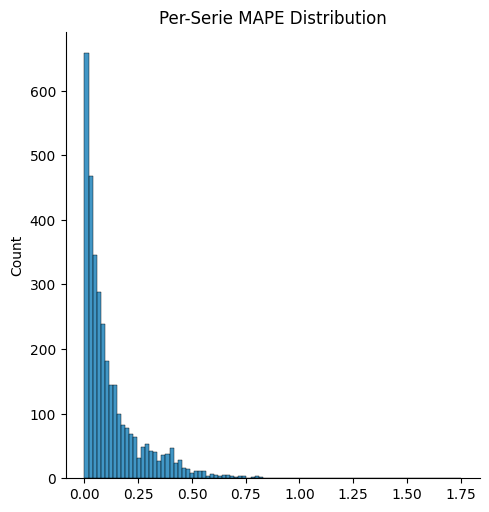

In [38]:
sns.displot(mape_list)
plt.title('Per-Serie MAPE Distribution')
plt.show()

In [40]:
pd.Series(mape_list).describe()

count    3410.000000
mean        0.127090
std         0.154725
min         0.000033
25%         0.025692
50%         0.071164
75%         0.167565
max         1.752197
dtype: float64